In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

import xgboost as xgb

In [2]:
df = pd.read_csv('archive/PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
#set date as index

df = df.set_index('Datetime')

In [5]:
#change datatype of Datetime to datetime

df.index = pd.to_datetime(df.index)

<AxesSubplot:title={'center':'PJME Energy Consumption in MW'}, xlabel='Year'>

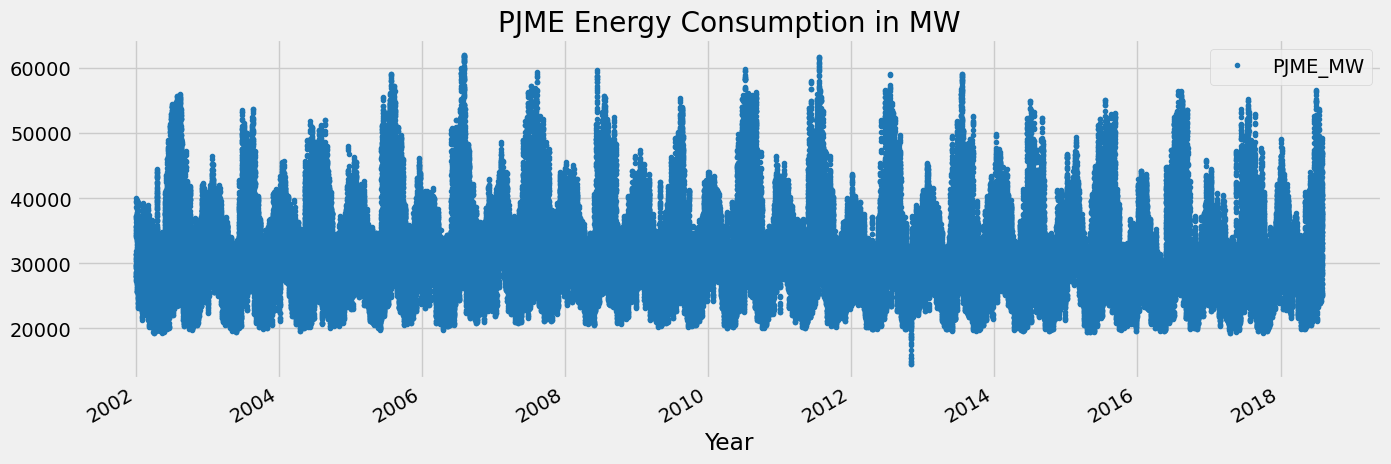

In [6]:
#plot the data

df.plot(style='.',
        figsize=(15,5),
        title='PJME Energy Consumption in MW',
        xlabel='Year',
        legend=True,
        color = color_pal[0])

Train / Test Split

In [7]:
#using dates less than 2015

train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

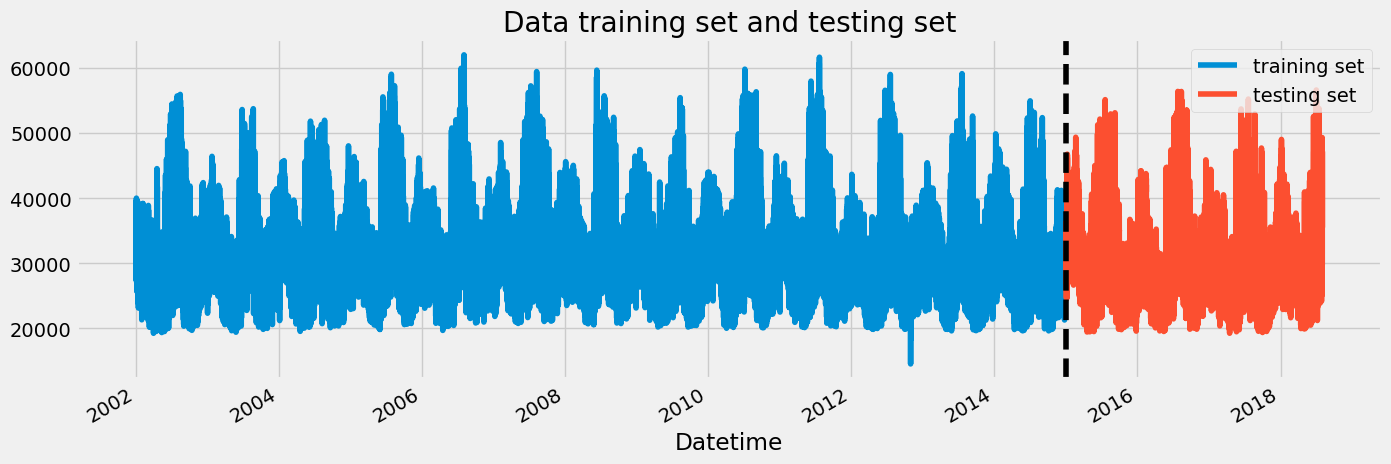

In [8]:
#plot both datasets using matplotlib as a subplot

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='training set', title='Data training set and testing set')
test.plot(ax=ax, label='testing set')

# creating a line to separate the training set from the testing set
ax.axvline("2015-01-01", color='black', ls='--')
ax.legend(['training set', 'testing set'])
plt.show()

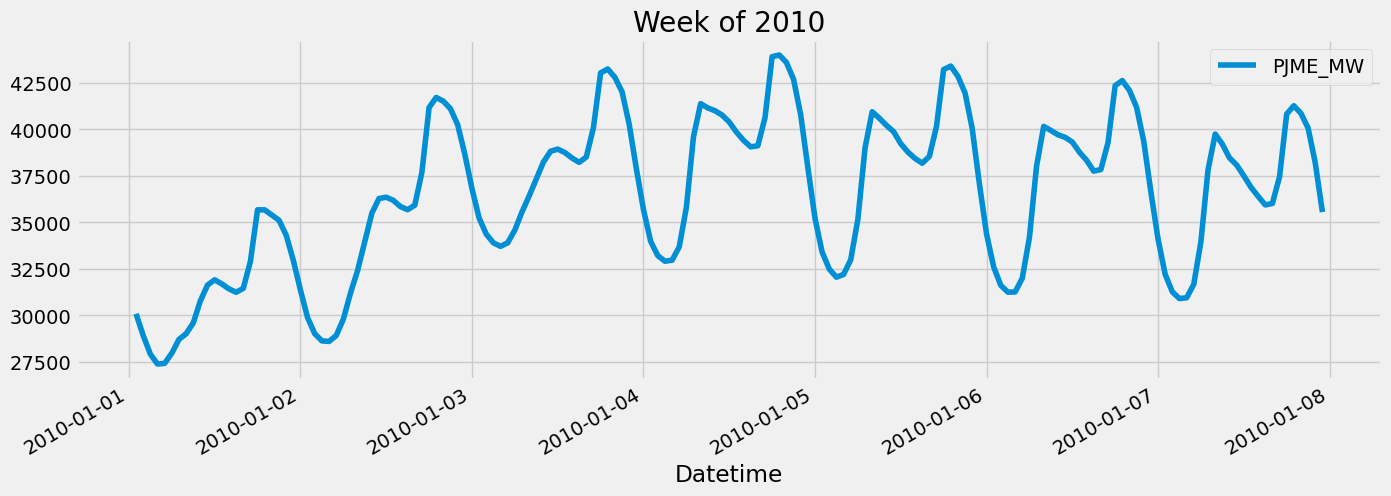

In [9]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].plot(figsize=(15,5), legend=True, title='Week of 2010')
plt.show()

Feature Engineering

In [10]:
#create a new column for the hour and day
def create_features(df):

    """"
    create time series based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    return df

df = create_features(df)

Visualize Feature/Target Correlation

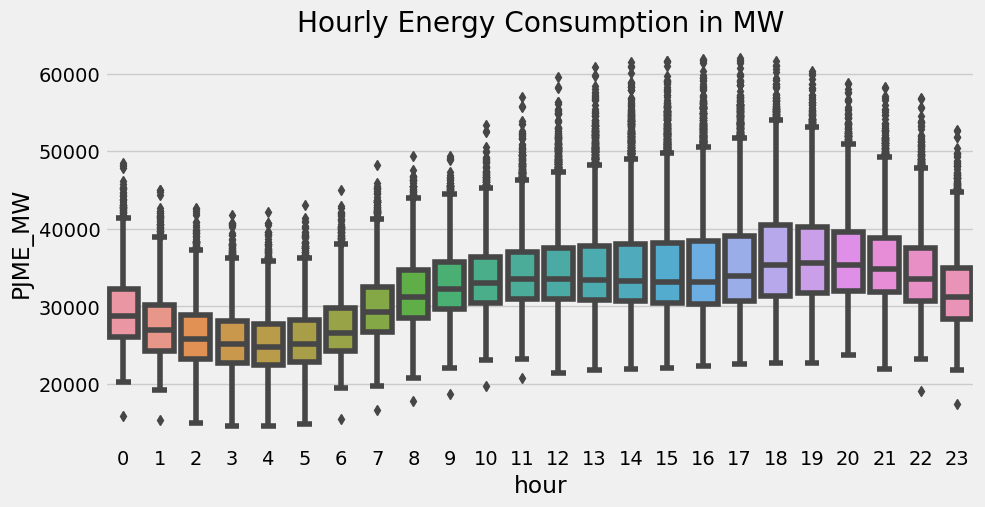

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('Hourly Energy Consumption in MW')
plt.show()

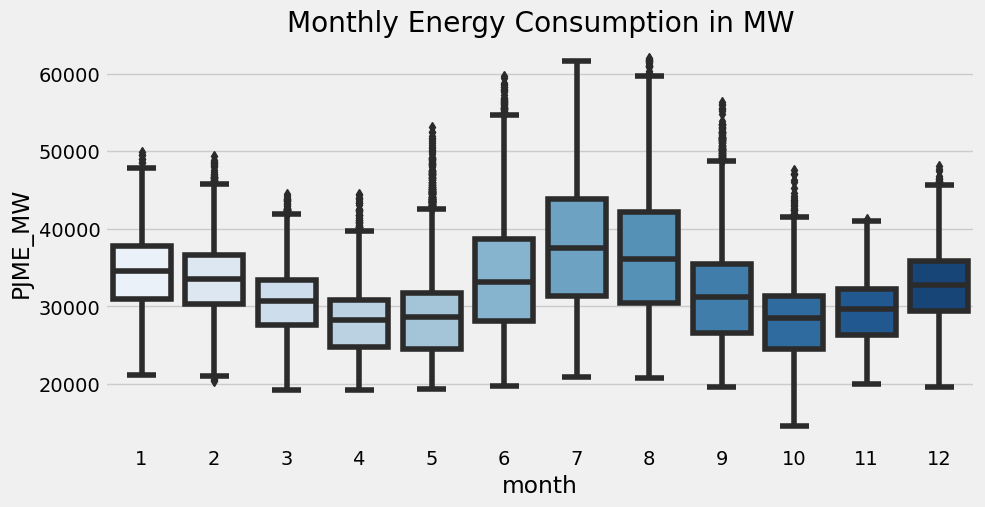

In [12]:
#monthly

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df, x='month', y='PJME_MW', palette="Blues")
ax.set_title('Monthly Energy Consumption in MW')
plt.show()

Create Model

In [13]:
from sklearn.metrics import mean_squared_error #will give us more accurate error

In [14]:
train = create_features(train)
test = create_features(test)

In [15]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
#regression model

model = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50, #avoid overfitting and save time
    learning_rate=0.01, #learning rate for xgboost 
)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100 #show progress bar every 100 iterations
)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Feature Importance

In [18]:
model.feature_importances_ #shows the importance of each feature 

array([0.44880438, 0.1586678 , 0.03331862, 0.22815645, 0.02263376,
       0.10841895], dtype=float32)

In [19]:
#create a dataframe with the importance of each feature

feature_importances = pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns=['importance'])

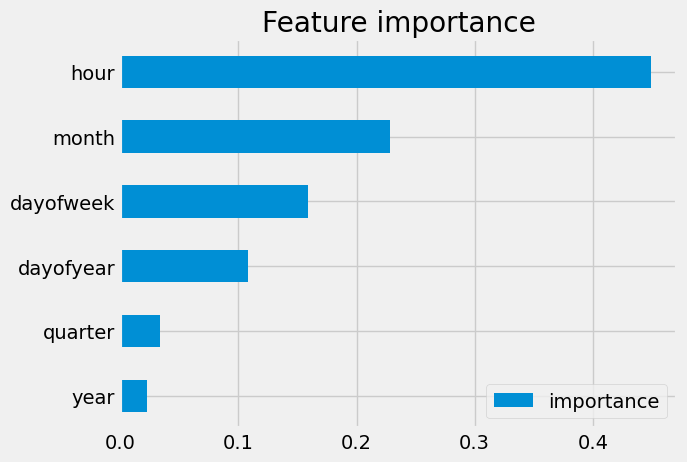

In [20]:
feature_importances.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()
#model has been using the most important features of the hourly energy consumption in MW

Forcasting

In [21]:
model.predict(X_test)

array([31861.592, 28268.078, 27164.314, ..., 34941.773, 33248.86 ,
       31850.736], dtype=float32)

In [22]:
#create a new column called prediction

test['prediction'] = model.predict(X_test)

#merge the dataframes

df = df.merge(test[["prediction"]], how='left', left_index=True, right_index=True)

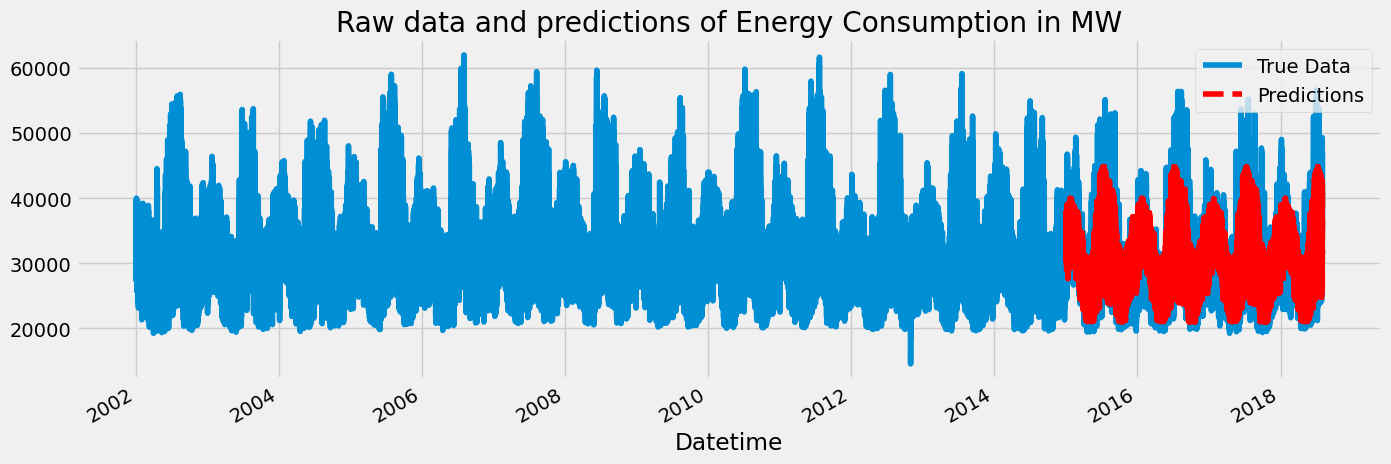

In [23]:
ax = df[["PJME_MW"]].plot(figsize=(15,5))
df[["prediction"]].plot(ax=ax, color='red', style='--')
ax.set_title('Raw data and predictions of Energy Consumption in MW')
plt.legend(['True Data', 'Predictions'])
plt.show()

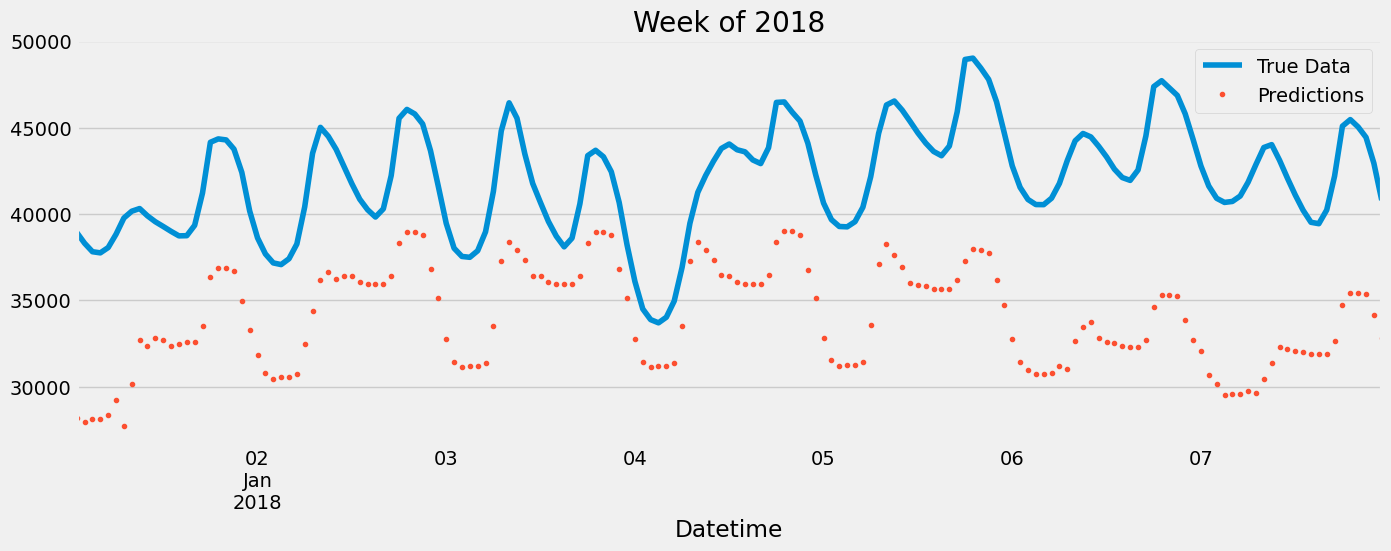

In [24]:
#ploting the predictions of week of 2018

ax = df.loc[(df.index > '2018-01-01') & (df.index < '2018-01-08')]["PJME_MW"] \
    .plot(figsize=(15,5), title='Week of 2018')

df.loc[(df.index > '2018-01-01') & (df.index < '2018-01-08')]["prediction"] \
    .plot(style='.')
plt.legend(['True Data', 'Predictions'])
plt.show()

In [25]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])) #running rmse on the test set
print(f"RMSE on test set: {score:0.2f}")

RMSE on test set: 3715.93


calculate the error

- look at the worst and best predictions

In [26]:
test["error"] = np.abs(test[TARGET] - test['prediction'])

In [27]:
test["date"] = test.index.date

In [28]:
test.groupby("date")["error"].mean().sort_values(ascending = False).head() #worse predictions on the test set are on the weekends

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

next steps

cross validation
- add more features
- add more models
- add more features
- add more models